<a href="https://colab.research.google.com/github/kartikgill/The-GAN-Book/blob/main/Skill-03/Convergence%20Failure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing useful libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [2]:
import tensorflow
print (tensorflow.__version__)

2.4.1


# Download and show data

11493376/11490434 [==============================] - 0s 0us/step
Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


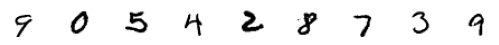

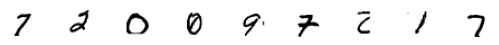

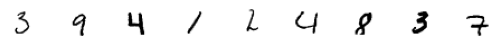

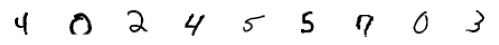

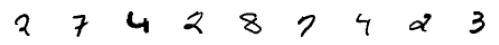

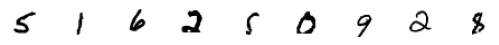

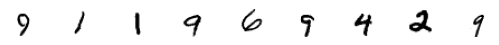

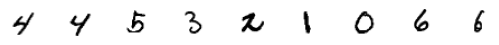

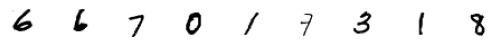

In [3]:
from tensorflow.keras.datasets import mnist

(trainX, trainY), (testX, testY) = mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testY.shape))

for k in range(9):
    plt.figure(figsize=(9, 6))
    for j in range(9):
        i = np.random.randint(0, 10000)
        plt.subplot(990 + 1 + j)
        plt.imshow(trainX[i], cmap='gray_r')
        #plt.title(trainY[i])
        plt.axis('off')
    plt.show()

# Data Normalization

In [4]:
trainX = [image/255.0 for image in trainX]
testX = [image/255.0 for image in testX]

trainX = np.reshape(trainX, (60000, 28, 28, 1))
testX = np.reshape(testX, (10000, 28, 28, 1))

print (trainX.shape, testX.shape, trainY.shape, testY.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1) (60000,) (10000,)


# Define Generator Model

In [5]:
random_input = tensorflow.keras.layers.Input(shape = 50)

x = tensorflow.keras.layers.Dense(28*28, activation='relu')(random_input)
x = tensorflow.keras.layers.Reshape((28, 28, 1))(x)

generated_image = tensorflow.keras.layers.Activation('sigmoid')(x)

generator_network = tensorflow.keras.models.Model(inputs=random_input, outputs=generated_image)
generator_network.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
dense (Dense)                (None, 784)               39984     
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
activation (Activation)      (None, 28, 28, 1)         0         
Total params: 39,984
Trainable params: 39,984
Non-trainable params: 0
_________________________________________________________________


# Define Discriminator

In [6]:
image_input = tensorflow.keras.layers.Input(shape=(28, 28, 1))

x = tensorflow.keras.layers.Flatten()(image_input)
x = tensorflow.keras.layers.Dense(512, activation='relu')(x)
x = tensorflow.keras.layers.Dense(256, activation='relu')(x)
x = tensorflow.keras.layers.Dense(128, activation='relu')(x)
x = tensorflow.keras.layers.Dense(1)(x)

real_vs_fake_output = tensorflow.keras.layers.Activation('sigmoid')(x)

discriminator_network = tensorflow.keras.models.Model(inputs=image_input, outputs=real_vs_fake_output)
discriminator_network.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0   

In [7]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
discriminator_network.compile(loss='binary_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

# Define combined model: GAN

In [8]:
discriminator_network.trainable=False

g_output = generator_network(random_input)
d_output = discriminator_network(g_output)

gan_model = tensorflow.keras.models.Model(random_input, d_output)
gan_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
model (Functional)           (None, 28, 28, 1)         39984     
_________________________________________________________________
model_1 (Functional)         (None, 1)                 566273    
Total params: 606,257
Trainable params: 39,984
Non-trainable params: 566,273
_________________________________________________________________


# Compiling Models

In [9]:
gan_model.compile(loss='binary_crossentropy', optimizer=adam_optimizer)

# Define Data Generators

In [10]:
# Indices of Zero Images
#indices = list(np.where(trainY==0)[0])
indices = [i for i in range(60000)]

def get_random_noise(batch_size, noise_size):
    random_values = np.random.randn(batch_size*noise_size)
    random_noise_batch = np.reshape(random_values, (batch_size, noise_size))
    return random_noise_batch

def get_fake_samples(generator_network, batch_size, noise_size):
    random_noise_batch = get_random_noise(batch_size, noise_size) 
    fake_samples = generator_network.predict_on_batch(random_noise_batch)
    return fake_samples

def get_real_samples(batch_size):
    random_indices = np.random.choice(indices, size=batch_size)
    real_images = trainX[np.array(random_indices),:]
    return real_images

def show_generator_results(generator_network):
    fake_samples = get_fake_samples(generator_network, 81, noise_size)

    counter = 0
    for k in range(9):
        plt.figure(figsize=(9, 6))
        for j in range(9):
            plt.subplot(990 + 1 + j)
            plt.imshow(fake_samples[counter, :, :, 0], cmap='gray_r')
            counter += 1
            plt.axis('off')
        plt.show()
    return

# Training GAN

In [ ]:
epochs = 500
batch_size = 60
steps = 500
noise_size = 50

losses_d = []
losses_g = []

for i in range(0, epochs):
    if (i%5 == 0):
        show_generator_results(generator_network)
    for j in range(steps):
        fake_samples = get_fake_samples(generator_network, batch_size//2, noise_size)
        real_samples = get_real_samples(batch_size=batch_size//2)

        fake_y = np.zeros((batch_size//2, 1))
        real_y = np.ones((batch_size//2, 1))
        
        input_batch = np.vstack((fake_samples, real_samples))
        output_labels = np.vstack((fake_y, real_y))
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d = discriminator_network.train_on_batch(input_batch, output_labels)
        
        gan_input = get_random_noise(batch_size, noise_size)
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        gan_output = np.ones((batch_size))
        
        # Updating Generator weights
        discriminator_network.trainable=False
        loss_g = gan_model.train_on_batch(gan_input, gan_output)
        
        losses_d.append(loss_d[0])
        losses_g.append(loss_g)
        
        if j%50 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g))
            

# Loss chart

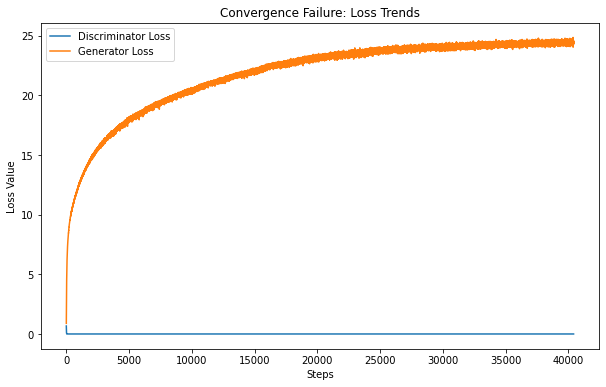

In [12]:
steps = [i for i in range(len(losses_d))]
plt.figure(figsize=(10, 6))
plt.plot(losses_d)
plt.plot(losses_g)
plt.xlabel('Steps')
plt.ylabel('Loss Value')
plt.title("Convergence Failure: Loss Trends")
plt.legend(['Discriminator Loss', 'Generator Loss'])
plt.show()